Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Const

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest/mest

/content/drive/MyDrive/Colab Notebooks/mest/mest


In [3]:
# FOLDER = "images"

# OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
# TRAIN_DIR = f"{FOLDER}/train"

# OLD_TEST_DIR = f"{FOLDER}/Конволюты"
# TEST_DIR = f"{FOLDER}/test"

# NEW_TRAIN_DIR = f"{FOLDER}/new_train"
# NEW_TEST_DIR = f"{FOLDER}/new_test"
# IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8
PATH = "m3.pth"
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Библиотеки

In [4]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 900_000_000

import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

# import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import confusion_matrix as conf_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
import seaborn as sns

def open_image(image):
    # чтобы изображение не поворачивалось на 90 градусов, если w < h
    # https://stackoverflow.com/questions/4228530/pil-thumbnail-is-rotating-my-image
    img = Image.open(image)
    img = ImageOps.exif_transpose(img)
    return img

# torchvision.transforms

In [5]:
data_transform = transforms.Compose([
    # transforms.Resize(size=(224, 224)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomCrop(300),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [7]:
# https://www.learnpytorch.io/04_pytorch_custom_datasets/

def plot_transformed_images(image_paths, transform, n=8):

    random_image_paths = random.sample(image_paths, k=n)

    # random_image_paths = image_paths

    for image_path in random_image_paths:

        f = Image.open(image_path)
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        # ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.size()}")
        # ax[1].axis("off")

In [8]:
files_names = sorted(os.listdir(DATA_POS))
image_paths  = [os.path.join(DATA_POS, i) for i in files_names]

plot_transformed_images(image_paths, transform=data_transform)

Output hidden; open in https://colab.research.google.com to view.

# Dataset

In [9]:
"seed_everything(42)"

'seed_everything(42)'

In [10]:
def seed_everything(seed: int):
    # import random, os
    # import numpy as np
    # import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [11]:
# https://stackoverflow-com.translate.goog/questions/51677788/data-augmentation-in-pytorch?_x_tr_sl=auto&_x_tr_tl=ru&_x_tr_hl=ru

# class experimental_dataset(Dataset):
#     def __init__(self, data, transform):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data.shape[0])

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         item = self.transform(item)
#         return item

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])

# x = torch.rand(8, 1, 2, 2)
# print(x)

# dataset = experimental_dataset(x, transform)

# for item in dataset:
#     print(item)


In [12]:
def pos_neg(dataloader):
    num_pos = num_neg = num = 0

    for batch in dataloader:
        images, labels = batch

        col = images.size(0)
        pos = labels.sum()
        # print(images.size(0))

        num += col
        num_pos += pos
        num_neg += col - pos

    return {"1":num_pos.item(), "0":num_neg.item(), "total":num}

In [13]:
class Positive_Dataset(Dataset):
    def __init__(self, images_dir, augmentation=1, transform=data_transform):
        # self.images_dir = images_dir
        self.transform = transform
        self.augmentation = augmentation

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]

        self.real_len = len(files_names)

    def __len__(self):
        return self.augmentation * len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx % self.real_len])
        # print("QQQQQQQQQQQQQ 1")
        return self.transform(image), 1


class Negative_Dataset(Dataset):
    def __init__(self, images_dir, augmentation=1, transform=data_transform):
        self.transform = transform
        self.augmentation = augmentation

        files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in files_names]

        self.real_len = len(files_names)

    def __len__(self):
        return self.augmentation * len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx % self.real_len])
        # print("QQQQQQQQQQQQQ 0")
        return self.transform(image), 0

In [14]:
pos_dataset = Positive_Dataset(DATA_POS, augmentation=11)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 242    (22)
Negative: 224    (224)
ConcatDataset: 466


In [15]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 372
 Test: 94


In [16]:
first = train_dataset[0]
print(first[0].shape, first[1])

torch.Size([3, 300, 300]) 0


In [17]:
# for i, j in enumerate(train_dataset):
#     print(j[1], j[0][0,0,0])
#     if i > 10:
#         break

In [18]:
# seed_everything(42)

In [19]:
# X_batch, y_batch = next(iter(x))
# X_batch[0]

In [20]:
# X_batch[0]

# Dataloader

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 47
 Test batches: 12


In [22]:
images, labels = next(iter(test_loader))
print(images.shape, labels)

torch.Size([8, 3, 300, 300]) tensor([1, 1, 1, 0, 1, 0, 0, 1])


In [23]:
# pos_neg(train_loader)

In [24]:
# pos_neg(test_loader)

In [25]:
def show_images(images, labels, n = 4):
    f, axes= plt.subplots(n//4, 4, figsize=(30,10))

    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы)
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

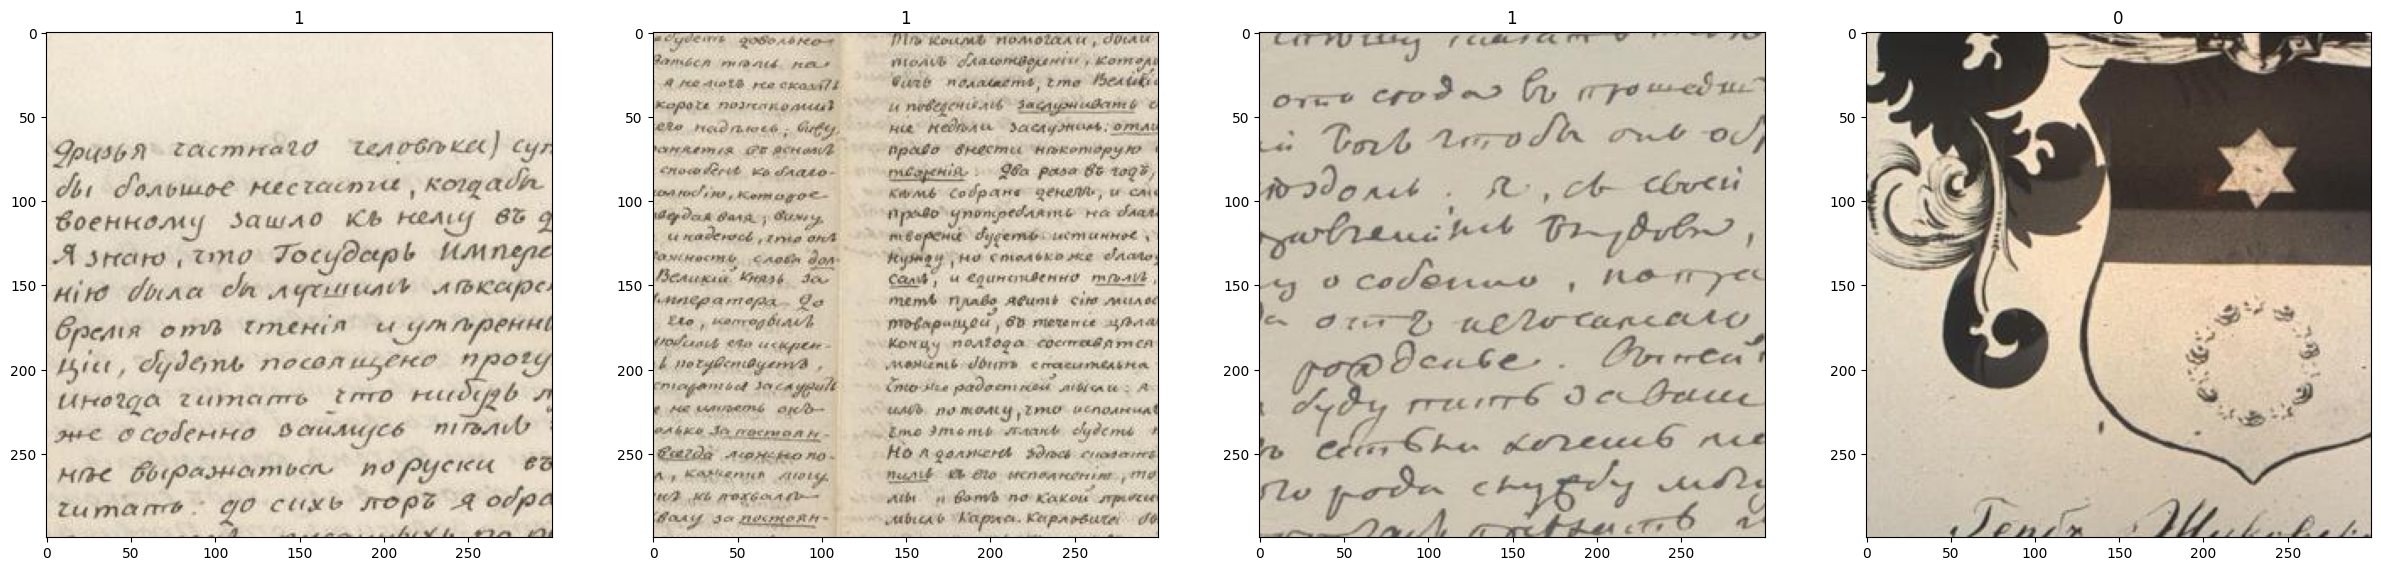

In [26]:
show_images(images, labels)

# Код

In [27]:
def get_predictions(model, dataloader, device=DEVICE):
    model.eval()
    pred_labels = []
    prob_labels = []
    true_labels = []
    X = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        true_labels.append(y_batch)
        X.append(X_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            y_prob = torch.softmax(logits, dim=1)[:, 1]

            pred_labels.append(y_pred)
            prob_labels.append(y_prob)


    pred_labels = torch.cat(pred_labels)
    prob_labels = torch.cat(prob_labels)
    true_labels = torch.cat(true_labels)
    X = torch.cat(X)

    # print("pred_labels, true_labels, prob_labels, X")
    return pred_labels.cpu(), true_labels, prob_labels.cpu(), X

In [40]:
def evaluate(model, dataloader, loss_fn, device=DEVICE):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            # вычисляем ответы сети как номера классов для каждой картинки
            y_pred = torch.argmax(logits, dim=1)

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch)

    # вычисляем итоговую долю правильных ответов
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, train_loader, val_loader, loss_fn, optimizer, n_epoch=3, device=DEVICE):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 50 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [29]:
# ВАШ КОД: постройте и обучите нейросеть
# model.children() выдает список сабмодулей нейросети
# в нашем случае это блоки resnet

def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [30]:
# model.eval()
# predicted_labels = []
# true_labels = []
# X = []

# for i, batch in enumerate(neg_loader):
#     X_batch, y_batch = batch
#     true_labels.append(y_batch)

#     with torch.no_grad():
#         logits = model(X_batch.to(device))
#         y_pred = torch.softmax(logits, dim=1)[:, 1]
#         predicted_labels.append(y_pred)
#         X.append(X_batch)

# predicted_labels = torch.cat(predicted_labels).cpu().numpy()
# true_labels = torch.cat(true_labels).numpy()
# X = torch.cat(X).numpy()

In [31]:
def confusion_matrix(y_true, y_pred):
    cm = conf_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 3))
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['0','1'],
                yticklabels=['0','1'])

    plt.xlabel('Prediction',fontsize=13)
    plt.ylabel('True',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    return cm

# freeze_layers

In [32]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [33]:
# dir(model)

In [34]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [35]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [36]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [37]:
model.load_state_dict(torch.load(PATH))

FileNotFoundError: [Errno 2] No such file or directory: 'm3.pth'

# train

In [41]:
%time
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=5)
torch.save(model.state_dict(), PATH)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Epoch: 1
Эпоха 1/5: val лосс и accuracy: 0.5498714049657186 0.7553192
Epoch: 2
Эпоха 2/5: val лосс и accuracy: 0.5497051328420639 0.78723407
Epoch: 3
Эпоха 3/5: val лосс и accuracy: 0.5213128303488096 0.78723407
Epoch: 4
Эпоха 4/5: val лосс и accuracy: 0.4823300763964653 0.80851066
Epoch: 5
Эпоха 5/5: val лосс и accuracy: 0.45040230453014374 0.81914896


# Визуализация

In [42]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))


    num_pic = min(len(images), n)
    width, height = 4, num_pic // 4 + 1

    # plt.figure(figsize=(6.4 * width, 6))

    for i in range(num_pic):

        if i % width == 0:
            plt.figure(figsize=(6.4 * width, 6))

        # plt.subplot(height, width, i + 1)
        plt.subplot(1, width, i % width + 1)

        img = images[i]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        if torch.is_tensor(labels[i]):
            plt.title(labels[i].numpy())
        else:
            plt.title(labels[i])

        if i % width == width - 1:
            plt.tight_layout()
            plt.show()

    plt.show()

In [43]:
def show_result(model, dataset, threshold, greater = True, col = 8, seed = 42, sort = False):
    seed_everything(seed)

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

    y_pred, y_true, y_prob, X = get_predictions(model, loader)

    if sort:
        s, indices = torch.sort(y_prob)
        y_pred = y_pred[indices]
        y_prob = y_prob[indices]
        X = X[indices]

    if greater:
        idx = np.where(y_prob > threshold)[0]
    else:
        idx = np.where(y_prob < threshold)[0]


    sign = ">" if greater else "<"
    print(f"prob {sign} {threshold}\ncount : {len(idx)} out of {len(dataset)}")
    idx = idx[:col]
    print(f"pic idx : {list(idx)}")
    show_images(X[idx], y_prob[idx], n = col)

    return y_pred, y_true, y_prob, X

# eval

In [44]:
seed_everything(42)
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)

0.8010752688172043

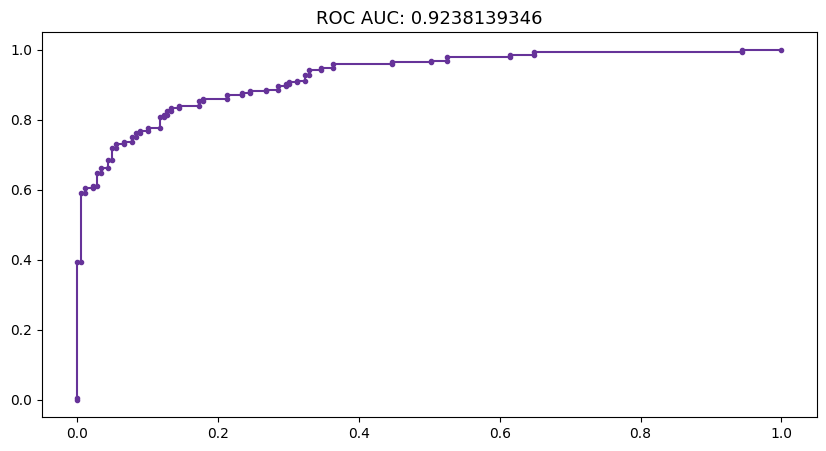

In [45]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(10, 5))
plt.title(f"ROC AUC: {roc_auc_score(y_true, y_prob):.10}", fontsize=13)
plt.plot(fpr, tpr, marker='.', color = 'rebeccapurple')
plt.show()

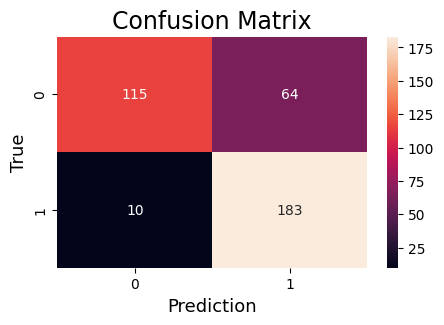

array([[115,  64],
       [ 10, 183]])

In [46]:
confusion_matrix(y_true, y_pred)

In [47]:
seed_everything(42)
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)

0.851063829787234

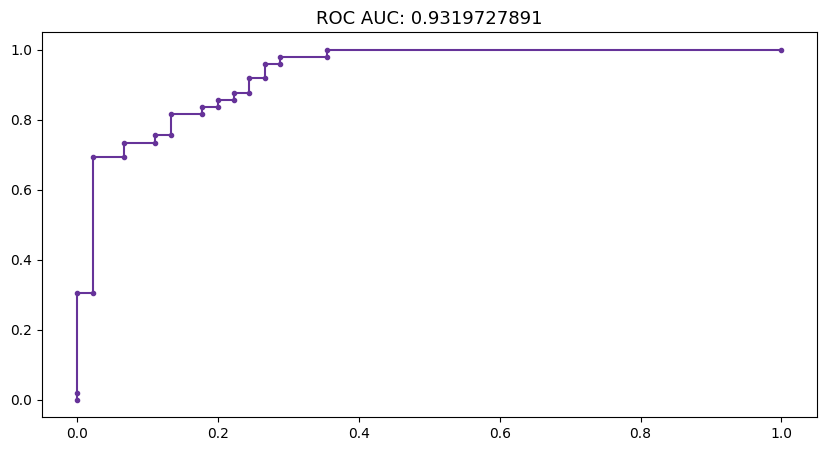

In [48]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(10, 5))
plt.title(f"ROC AUC: {roc_auc_score(y_true, y_prob):.10}", fontsize=13)
plt.plot(fpr, tpr, marker='.', color = 'rebeccapurple')
plt.show()

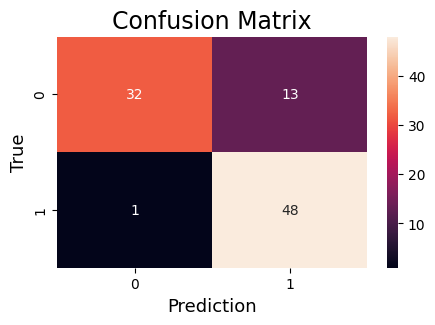

array([[32, 13],
       [ 1, 48]])

In [49]:
confusion_matrix(y_true, y_pred)

In [50]:
# ((y_pred == 1) * (y_true == 1)).sum()

# show

In [58]:
data_transform = transforms.Compose([
    # transforms.Resize(size=(224, 224)),
    # transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomCrop(300),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [59]:
pos_dataset = Positive_Dataset(DATA_POS, augmentation=11, transform = data_transform)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG, augmentation=1, transform = data_transform)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

Positive: 242    (22)
Negative: 224    (224)


In [60]:
# seed_everything(42)
# loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
#                                            shuffle=False)


# images, labels = next(iter(loader))
# print(images.shape, labels)
# show_images(images, labels)

In [61]:
# seed_everything(42)
# pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
#                                            shuffle=True)

# y_pred_pos, y_true_pos, y_prob_pos, X_pos = get_predictions(model, pos_loader)
# accuracy_score(y_pred_pos, y_true_pos)

In [62]:
# (y_prob > 0.5).float() == y_pred

(0.0, 1.0)

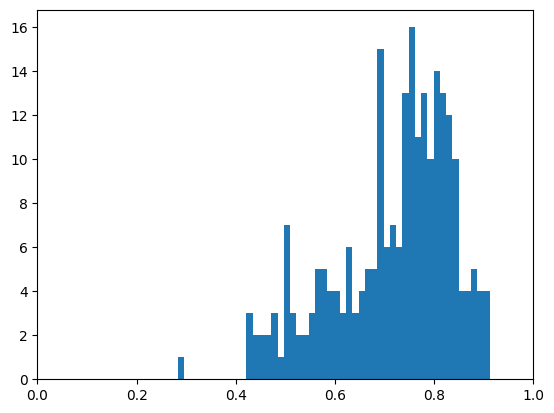

In [63]:
seed_everything(42)
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))

(0.0, 1.0)

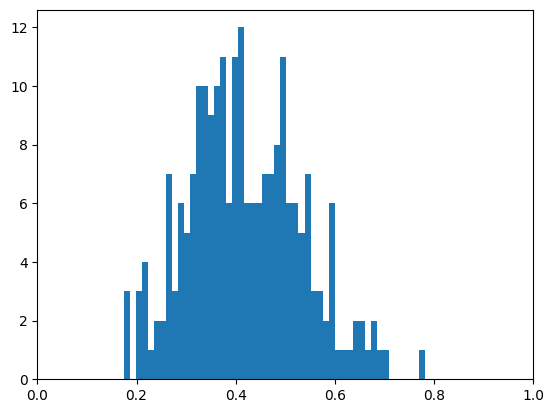

In [64]:
seed_everything(42)
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))

In [65]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater = True, col = 8)

Output hidden; open in https://colab.research.google.com to view.

In [66]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.5, greater = False, col = 8)

Output hidden; open in https://colab.research.google.com to view.

In [68]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.6, greater = True, col = 24)

Output hidden; open in https://colab.research.google.com to view.

In [69]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.6, greater = True, col = 16, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [73]:
s1 = [2, 9, 27, 37, 39, 46, 57, 63, 95, 97, 109, 179, 183]
s2 = [8, 19, 21, 31, 53, 61, 63, 93, 147, 171, 182, 192]

l = sorted(list(set(s1) & set(s2)))
l

[63]

In [71]:
l = [21, 179, 180]

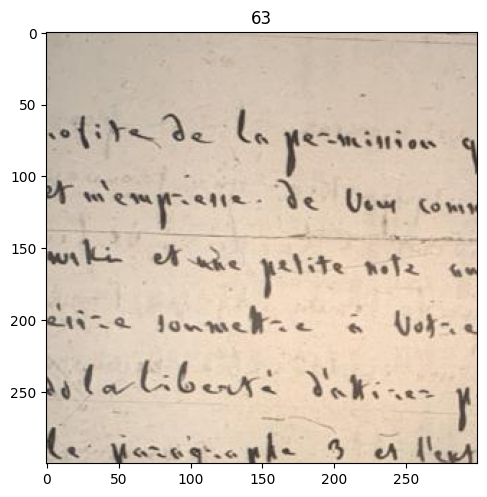

In [74]:
show_images(X[l], l, n = len(l))

In [ ]:
6# y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.2, greater = False, col = 8)

In [ ]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# neg = np.where(predicted_labels <= 0.8)[0]
# pos = np.where(predicted_labels > 0.8)[0]
# col = 8

In [ ]:
# show_images(X[pos[:col]], predicted_labels[pos[:col]], n = col)